In [81]:
!pip install dynesty corner

In [82]:
from scipy import stats
from scipy import optimize
from scipy.stats import norm, uniform
import numpy as np
import pylab as plt
import dynesty
from dynesty import utils as dyfunc
import corner

#Data Loading


###Transient Data

In [83]:
data = np.load('transient.npy')
t = data[:,0]
I = data[:,1]
yerr = data[:,2]

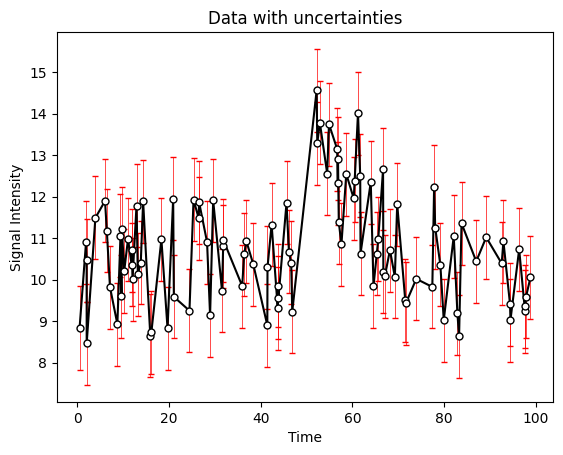

In [84]:
plt.errorbar(t, I, yerr=yerr, fmt='o-', color='black', ecolor='red', elinewidth=.5, capsize=2, markerfacecolor='white', markersize=5)
plt.title('Data with uncertainties')
plt.xlabel('Time')
plt.ylabel('Signal Intensity')
plt.show()

###Boson Data

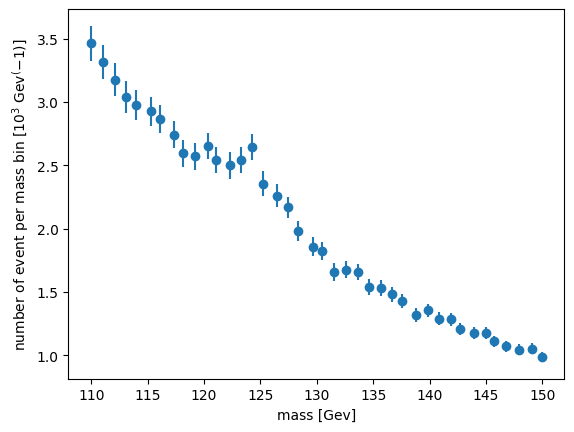

In [85]:
mass, eventpermassbin, eventerr = np.loadtxt('boson.txt',unpack=True)

plt.errorbar(mass, eventpermassbin, eventerr,fmt='o')
plt.xlabel('mass [Gev]')
plt.ylabel('number of event per mass bin [$10^3$ Gev$^(-1)$]');

#Work on Time Transient Data

###Exponential Pulse

In [86]:
def burst_model(t, params):
  b, A, t0, alpha = params

  result = np.zeros_like(t, dtype=float)
  mask_before = t < t0
  mask_after = t >= t0

  result[mask_before] = b
  result[mask_after] = b + A * np.exp(-alpha * (t[mask_after] - t0))
  return result

def log_likelihood_dynesty(theta):
  b, A, t0, log_alpha = theta
  alpha = np.exp(log_alpha)
  model = burst_model(t, (b, A, t0, alpha))
  return -0.5 * np.sum(((I - model) / yerr)**2 + np.log(2 * np.pi * yerr**2))

def prior_transform(unit_cube):
  u_b, u_A, u_t0, u_log_alpha = unit_cube

  b = 0 + 50 * u_b                # b in [0, 50]
  A = 0 + 50 * u_A                # A in [0, 50]
  t0 = 0 + 100 * u_t0             # t0 in [0, 100]
  log_alpha = -5 + 10 * u_log_alpha  # log_alpha in [-5, 5]

  return np.array([b, A, t0, log_alpha])

In [87]:
ndim = 4

sampler = dynesty.NestedSampler(log_likelihood_dynesty, prior_transform, ndim)
sampler.run_nested()
results = sampler.results

3951it [00:46, 18.95it/s, bound: 65 | nc: 248 | ncall: 65729 | eff(%):  6.011 | loglstar:   -inf < -178.542 <    inf | logz: -185.297 +/-  0.107 | dlogz: 34.810 >  0.509]/usr/local/lib/python3.11/dist-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3972it [00:49,  8.75it/s, bound: 70 | nc: 41 | ncall: 69208 | eff(%):  5.739 | loglstar:   -inf < -178.410 <    inf | logz: -185.283 +/-  0.107 | dlogz: 34.754 >  0.509] /usr/local/lib/python3.11/dist-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform

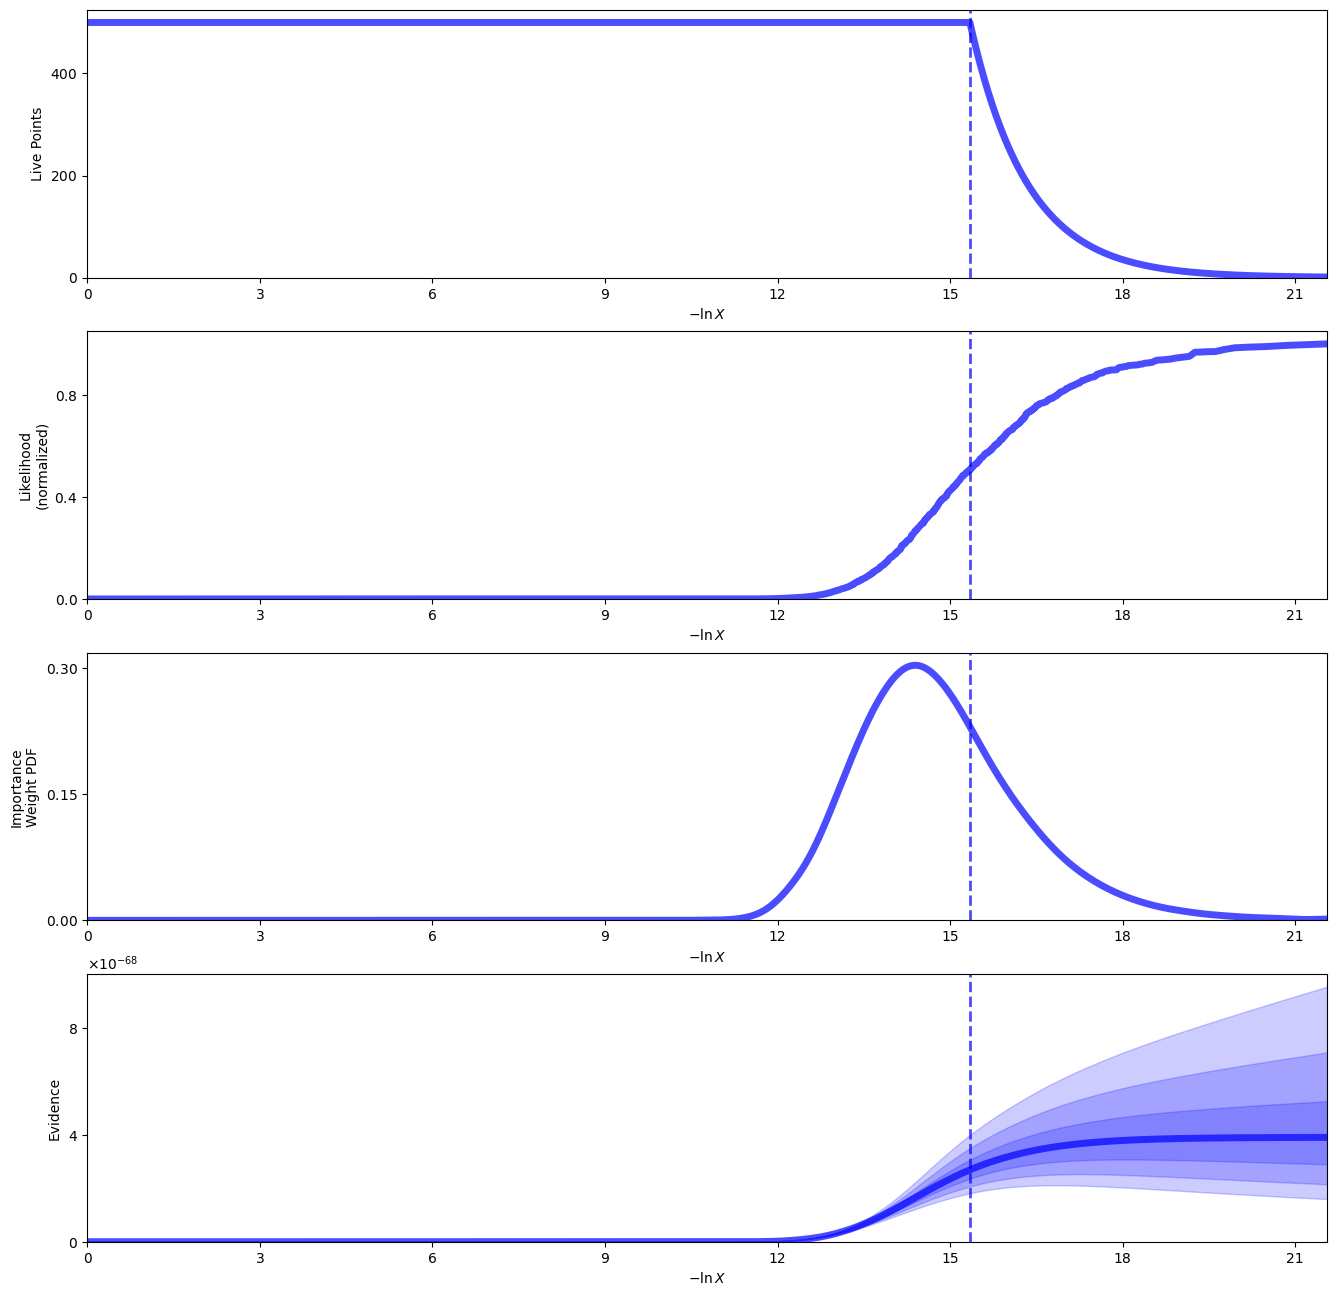

In [88]:
from dynesty import plotting as dyplot

rfig, raxes = dyplot.runplot(results)

In [89]:
samples = results.samples                # shape (n_samples, ndim)
log_weights = results.logwt
burst_model_log_evidence = results.logz[-1]            # final log evidence
weights = np.exp(log_weights - burst_model_log_evidence)

posterior_samples = dyfunc.resample_equal(samples, weights)

In [90]:
b_vals      = posterior_samples[:, 0]
A_vals      = posterior_samples[:, 1]
t0_vals     = posterior_samples[:, 2]
alpha_vals  = np.exp(posterior_samples[:, 3])

b_median = np.median(b_vals)
A_median = np.median(A_vals)
t0_median = np.median(t0_vals)
alpha_median = np.median(alpha_vals)

print(f'b_median = {b_median}')
print(f'A_median = {A_median}')
print(f't0_median = {t0_median}')
print(f'alpha_median = {alpha_median}')

b_median = 10.292921296527084
A_median = 5.392251721504699
t0_median = 49.23789688019619
alpha_median = 0.12215182760242926


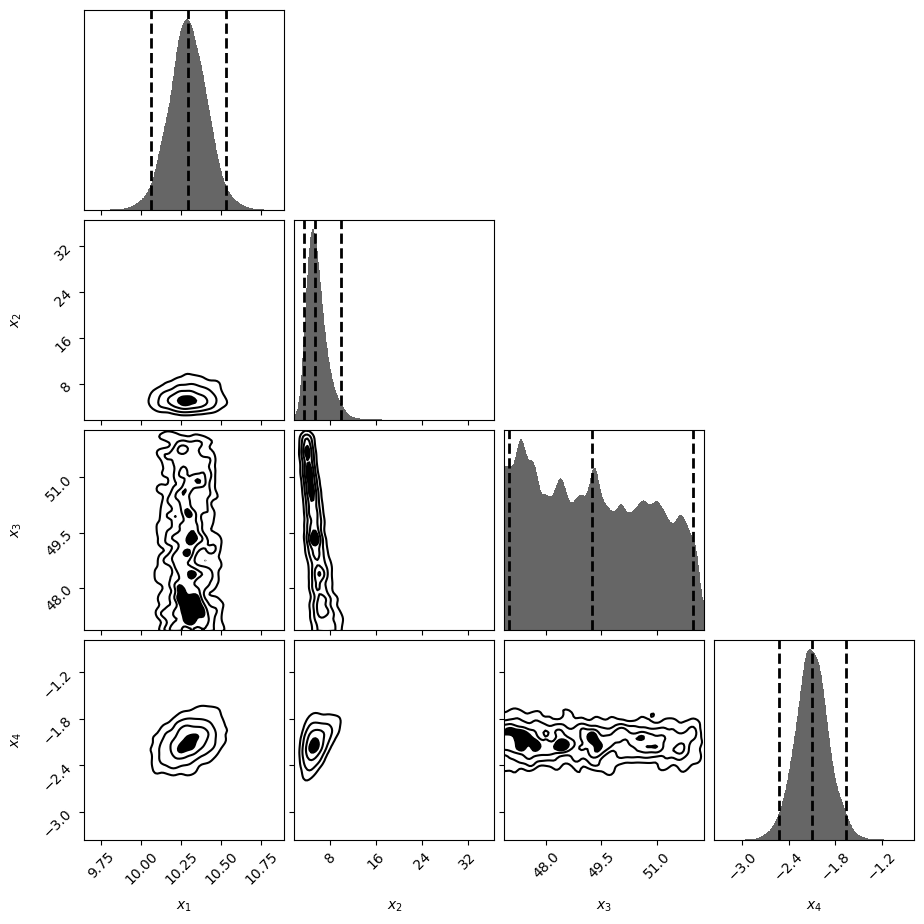

In [91]:
cfig, caxes = dyplot.cornerplot(results)

The estimated values agree with those found using MCMC

In [92]:
burst_model_evidence = np.exp(burst_model_log_evidence)
print("Bayesian evidence", burst_model_evidence)

Bayesian evidence 3.9084774160061795e-68


###Gaussian Pulse Model

In [93]:
def gaussian_model(t, params):
  b, A, t0, sigma_w = params

  return b + A * np.exp(-(t - t0)**2 / (2 * sigma_w**2))

def prior_transform_gaussian_pulse(unit_cube):
  u_b, u_A, u_t0, u_ln_sigma_w = unit_cube

  b = 0 + 50 * u_b                    # b in [0, 50]
  A = 0 + 50 * u_A                    # A in [0, 50]
  t0 = 0 + 100 * u_t0                 # t0 in [0, 100]
  ln_sigma_w = -5 + 10 * u_ln_sigma_w # ln_sigma_w in [-5, 5]

  return np.array([b, A, t0, ln_sigma_w])

def log_likelihood_gaussian_pulse(theta):
  b, A, t0, ln_sigma_w = theta
  sigma_w = np.exp(ln_sigma_w)
  model = gaussian_model(t, (b, A, t0, sigma_w))
  return -0.5 * np.sum(((I - model) / yerr)**2 + np.log(2 * np.pi * yerr**2))

In [94]:
sampler = dynesty.NestedSampler(log_likelihood_gaussian_pulse, prior_transform_gaussian_pulse, ndim)
sampler.run_nested()
results_gauss = sampler.results

2948it [00:09, 222.49it/s, bound: 15 | nc: 24 | ncall: 28998 | eff(%): 10.166 | loglstar:   -inf < -180.551 <    inf | logz: -187.770 +/-  0.113 | dlogz: 21.126 >  0.509]/usr/local/lib/python3.11/dist-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3946it [00:36, 27.52it/s, bound: 60 | nc: 70 | ncall: 62284 | eff(%):  6.335 | loglstar:   -inf < -178.436 <    inf | logz: -185.355 +/-  0.108 | dlogz: 32.485 >  0.509]/usr/local/lib/python3.11/dist-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform 

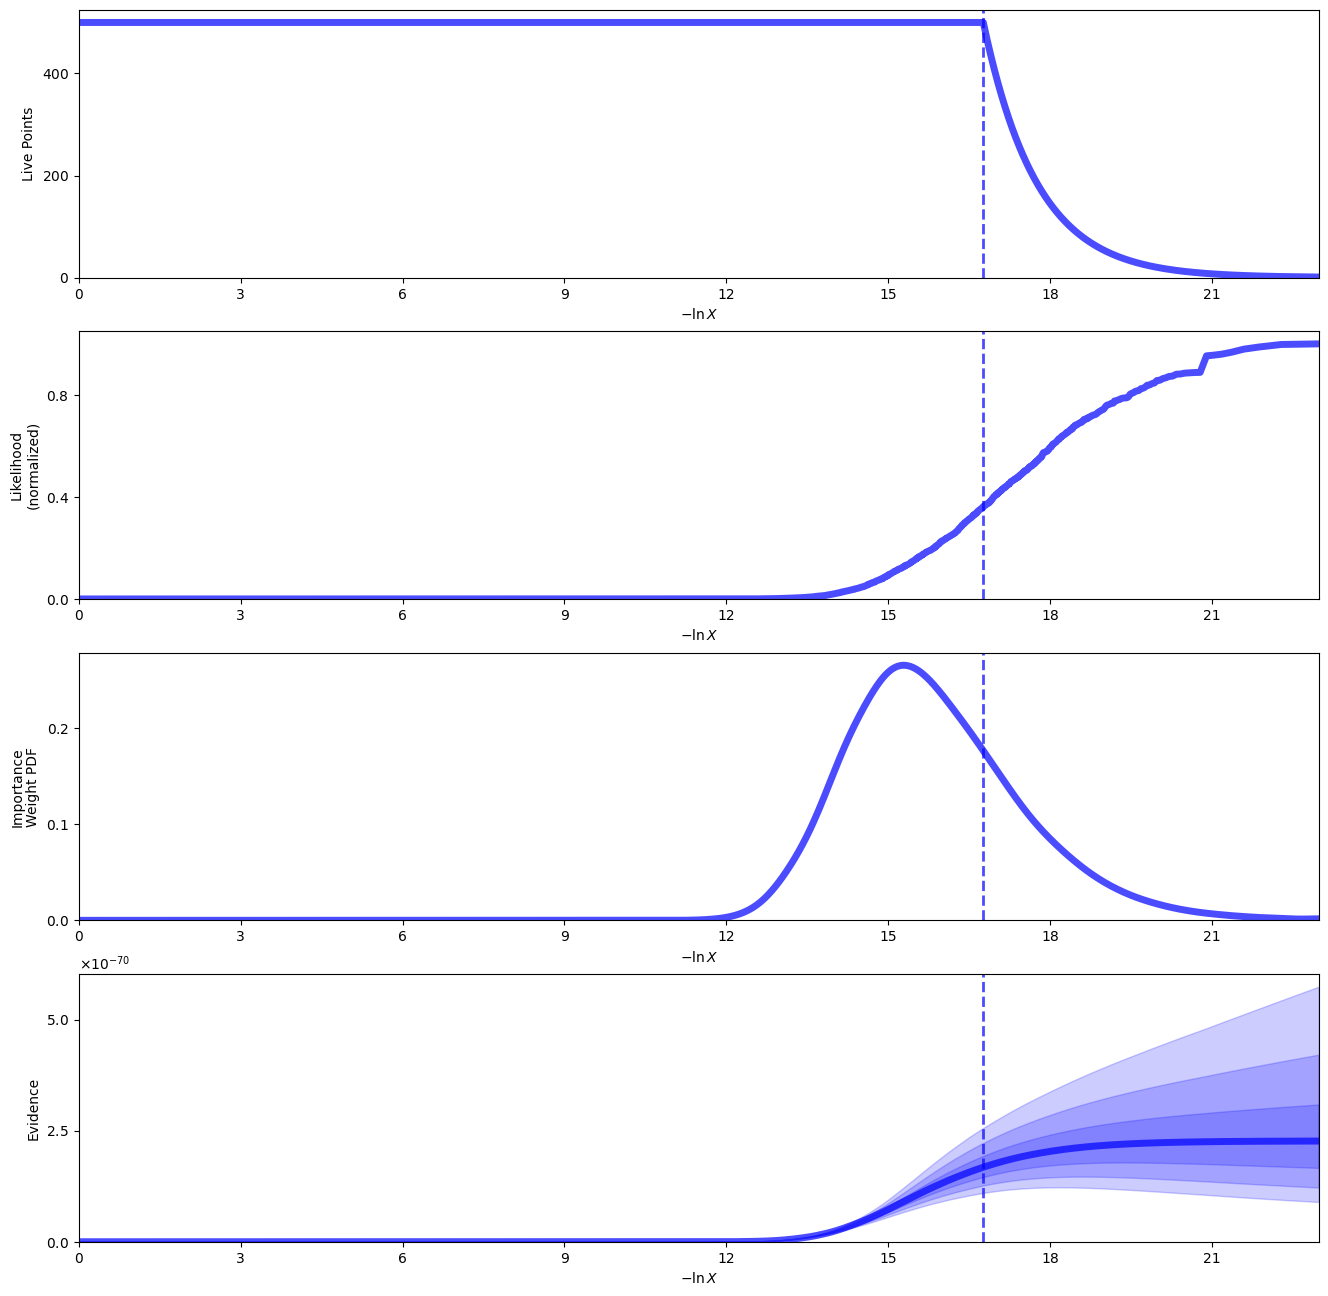

In [95]:
rfig, raxes = dyplot.runplot(results_gauss)

In [96]:
samples_g = results_gauss.samples
log_weights_g = results_gauss.logwt
log_evidence_g = results_gauss.logz[-1]
weights_g = np.exp(log_weights_g - log_evidence_g)

posterior_samples_g = dyfunc.resample_equal(samples_g, weights_g)

In [97]:
b_vals_g = posterior_samples_g[:, 0]
A_vals_g = posterior_samples_g[:, 1]
t0_vals_g = posterior_samples_g[:, 2]
alpha_vals_g = np.exp(posterior_samples_g[:, 3])

b_median_g = np.median(b_vals_g)
A_median_g = np.median(A_vals_g)
t0_median_g = np.median(t0_vals_g)
alpha_median_g = np.median(alpha_vals_g)

print(f'b_median = {b_median_g}')
print(f'A_median = {A_median_g}')
print(f't0_median = {t0_median_g}')
print(f'alpha_median = {alpha_median_g}')

b_median = 10.317298656581913
A_median = 2.748450070784749
t0_median = 55.38060675975568
alpha_median = 5.292371416303286


Also in this case the values are almost identical to those found using MCMC

In [98]:
gaussian_model_evidence = np.exp(log_evidence_g)
print("Bayesian evidence", gaussian_model_evidence)

Bayesian evidence 2.2670973477319155e-70


##Bayes Factor

In [99]:
bayes_factor = burst_model_evidence / gaussian_model_evidence
print("Bayes Factor", bayes_factor)

Bayes Factor 172.40007006829057


The Bayes factor is > 100, hence, following Jeffrey's scale, there is decisive evidence to prefer the model with an exponential pulse over the model with a  gaussian one

#Work on Higgs Boson data

###Model with signal

In [100]:
def model(mass, bg_amp, bg_exp, signal_amp, signal_mean, signal_width):
  background = bg_amp * (mass/110) ** (-bg_exp)
  signal = signal_amp * np.exp(-0.5 * ((mass - signal_mean) / signal_width) ** 2)

  return background + signal

def prior_transform(unit_cube):
  u_bg_amp, u_bg_exp, u_signal_amp, u_signal_mean, u_signal_width = unit_cube

  bg_amp = 1 + 4 * u_bg_amp              # [1, 5]
  bg_exp = 1 + 4 * u_bg_exp              # [1, 5]
  signal_amp = 0 + 2 * u_signal_amp      # [0, 2]
  signal_mean = 120 + 10 * u_signal_mean # [120, 130]
  signal_width = 0 + 5 * u_signal_width  # [0, 5]

  return np.array([bg_amp, bg_exp, signal_amp, signal_mean, signal_width])

def log_likelihood(params):
  bg_amp, bg_exp, signal_amp, signal_mean, signal_width = params

  if bg_amp <= 0 or signal_width <= 0 or signal_amp < 0:
      return -np.inf

  model_counts = model(mass, bg_amp, bg_exp, signal_amp, signal_mean, signal_width)
  return -0.5 * np.sum(((eventpermassbin - model_counts) / eventerr) ** 2 + np.log(2 * np.pi * eventerr**2))

In [101]:
ndim = 5
sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim)
sampler.run_nested()
results = sampler.results

7120it [00:19, 367.07it/s, +500 | bound: 43 | nc: 1 | ncall: 49287 | eff(%): 15.619 | loglstar:   -inf < 61.723 <    inf | logz: 48.162 +/-  0.166 | dlogz:  0.001 >  0.509]


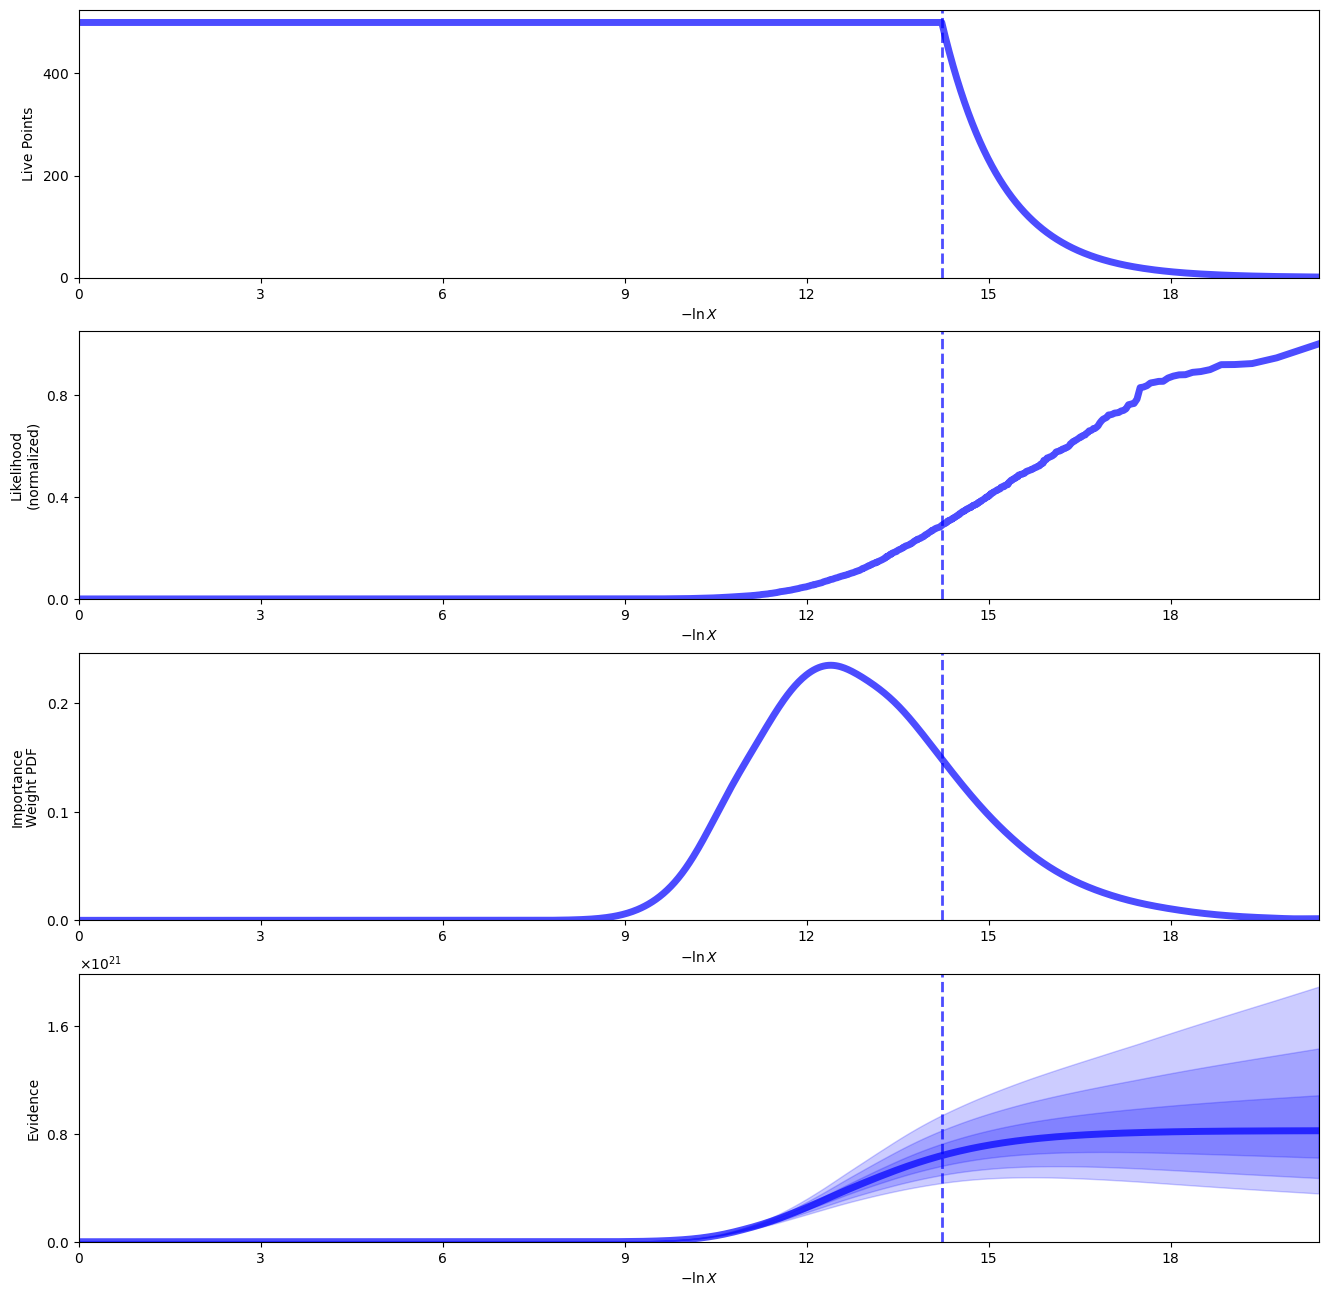

In [102]:
rfig, raxes = dyplot.runplot(results)

In [103]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
posterior_samples = dyfunc.resample_equal(samples, weights)

bg_amp_vals = posterior_samples[:, 0]
bg_exp_vals = posterior_samples[:, 1]
signal_amp_vals = posterior_samples[:, 2]
signal_mean_vals = posterior_samples[:, 3]
signal_width_vals = posterior_samples[:, 4]

In [104]:
bg_amp_median = np.median(bg_amp_vals)
bg_exp_median = np.median(bg_exp_vals)
signal_amp_median = np.median(signal_amp_vals)
signal_mean_median = np.median(signal_mean_vals)
signal_width_median = np.median(signal_width_vals)

print(f'bg_amp_median = {bg_amp_median}')
print(f'bg_exp_median = {bg_exp_median}')
print(f'signal_amp_median = {signal_amp_median}')
print(f'signal_mean_median = {signal_mean_median}')
print(f'signal_width_median = {signal_width_median}')

bg_amp_median = 3.4606692819370197
bg_exp_median = 3.983675054977696
signal_amp_median = 0.3775485303493772
signal_mean_median = 124.22773499400319
signal_width_median = 2.912675795937486


Once again, the values found through nested samplling correspond to those found using MCMC

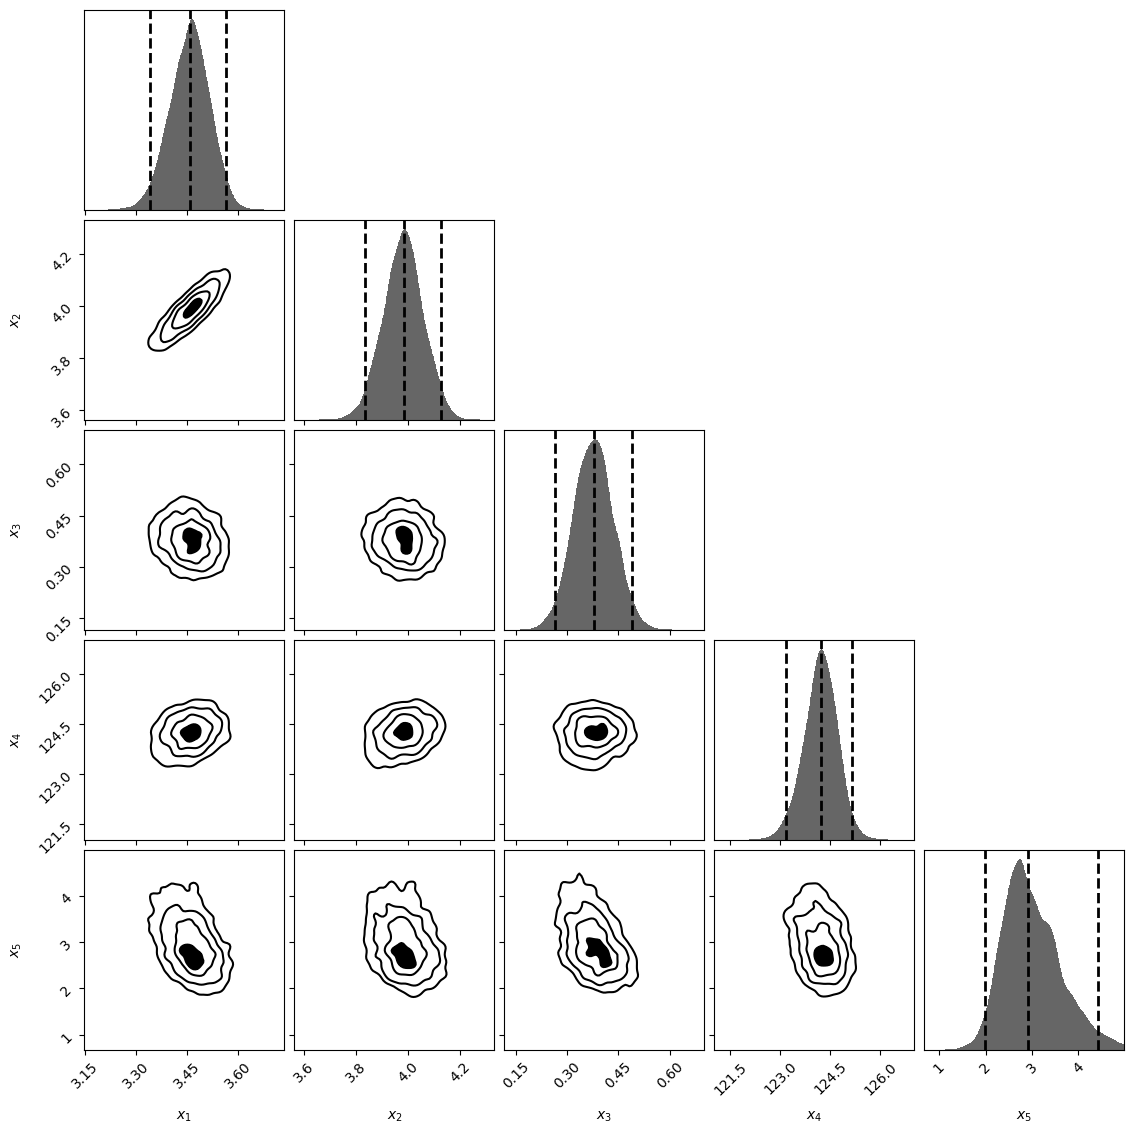

In [105]:
cfig, caxes = dyplot.cornerplot(results)

In [106]:
boson_signal_model_evidence = np.exp(results.logz[-1])
print("Bayesian evidence", boson_signal_model_evidence)

Bayesian evidence 8.249930190233185e+20


###Model without signal

In [107]:
def model_no_signal(mass, bg_amp, bg_exp):
  background = bg_amp * (mass/110) ** (-bg_exp)

  return background

def log_likelihood_no_signal(params):
  bg_amp, bg_exp = params

  if bg_amp <= 0:
      return -np.inf

  model_counts = model_no_signal(mass, bg_amp, bg_exp)
  return -0.5 * np.sum(((eventpermassbin - model_counts) / eventerr) ** 2 + np.log(2 * np.pi * eventerr**2))

def prior_transform_no_signal(unit_cube):
  u_bg_amp, u_bg_exp = unit_cube

  bg_amp = 1 + 4 * u_bg_amp              # [1, 5]
  bg_exp = 1 + 4 * u_bg_exp              # [1, 5]

  return np.array([bg_amp, bg_exp])

In [108]:
ndim = 2
sampler = dynesty.NestedSampler(log_likelihood_no_signal, prior_transform_no_signal, ndim)
sampler.run_nested()
results = sampler.results

4077it [00:05, 737.16it/s, +500 | bound: 6 | nc: 1 | ncall: 22207 | eff(%): 21.085 | loglstar:   -inf < 33.207 <    inf | logz: 25.902 +/-  0.112 | dlogz:  0.001 >  0.509]


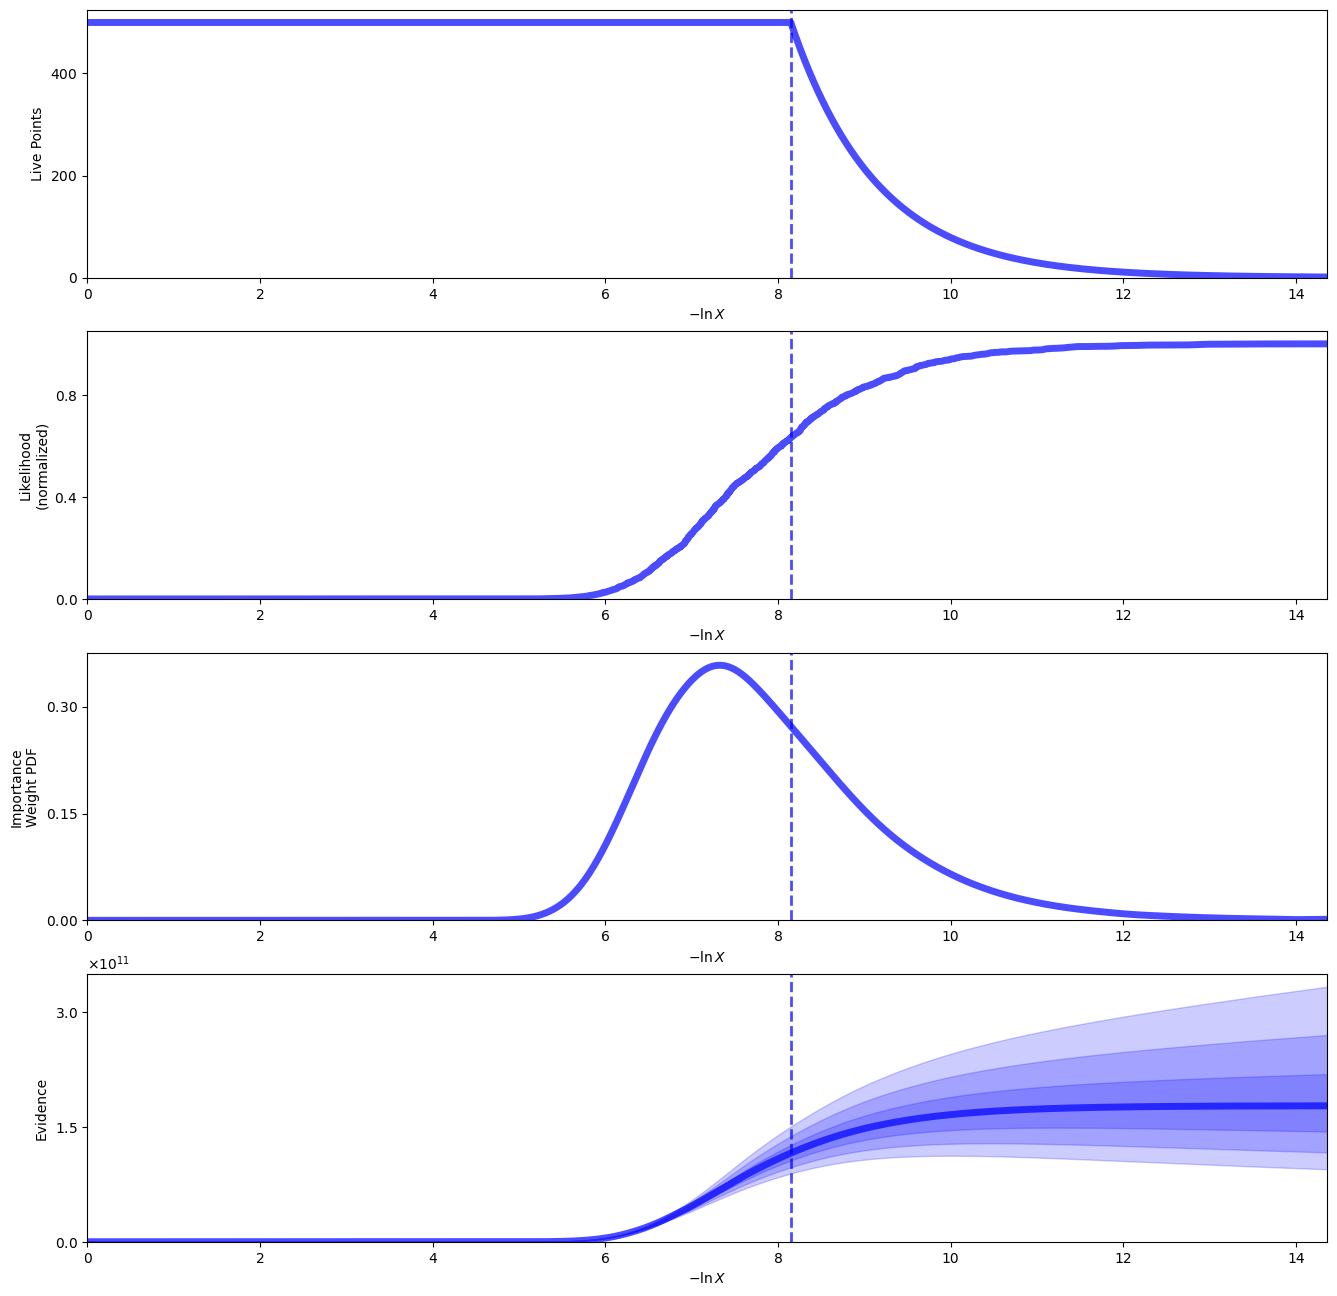

In [109]:
rfig, raxes = dyplot.runplot(results)

In [110]:
samples_ns, weights_ns = results.samples, np.exp(results.logwt - results.logz[-1])
posterior_samples_ns = dyfunc.resample_equal(samples_ns, weights_ns)

bg_amp_vals_ns = posterior_samples_ns[:, 0]
bg_exp_vals_ns = posterior_samples_ns[:, 1]

In [111]:
bg_amp_median_ns = np.median(bg_amp_vals_ns)
bg_exp_median_ns = np.median(bg_exp_vals_ns)

print(f'bg_amp_median = {bg_amp_median_ns}')
print(f'bg_exp_median = {bg_exp_median_ns}')

bg_amp_median = 3.624633440405037
bg_exp_median = 4.108755727573972


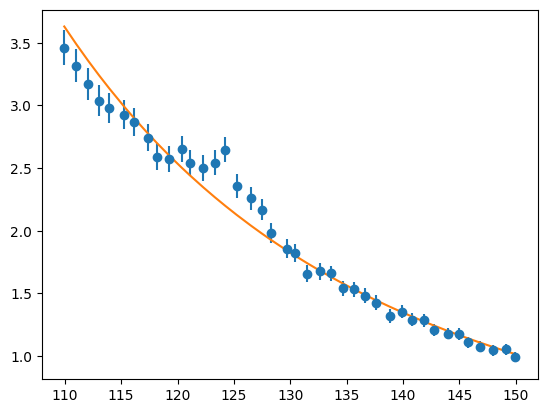

In [112]:
plt.errorbar(mass, eventpermassbin, yerr=eventerr, fmt='o', label='data')
plt.plot(mass, model_no_signal(mass, bg_amp_median_ns, bg_exp_median_ns), label='model')

In [113]:
boson_no_signal_model_evidence = np.exp(results.logz[-1])
print("Bayesian evidence", boson_no_signal_model_evidence)

Bayesian evidence 177444774153.4805


###Bayes Factor

In [114]:
bayes_factor = boson_signal_model_evidence / boson_no_signal_model_evidence
print("Bayes Factor", bayes_factor)

Bayes Factor 4649294536.618713


The Bayes factor is >> 100, hence I can state, gollowing Jeffrey's scale, that there is decisive evidence for the presence of the Higgs Boson signal in the data. This is compatible with what I found using Savage-Dickey approximation